# Tones, Frequency and Pitch on a Synthesizer Keyboard

In this notebook the concepts of **pitch** and **frequency** of a **note** are illustrated on a synthesizer keyboard.  
For simplicity reasons this notebook synthesizes **pure tones**(sinewaves).    
We also show the mapping to common **midi** notation.

Natural sounds from musical instruments or the human voice are much more complex and often (quasi)-periodic signals.  For these sounds the pitch percept corresponds typically to the main periodicity or equivalently to the fundamental frequency.
For more detailed elaboration look for demos on the subject of *Pitch & Timbre*.
  
By default we use simple 5msec ramping up and down of tones, to avoid some click like artificats at onset or offsets.
In the last demo we use triangular waves to make the sound a bit more keyboard like
You can vary You can play with a few other characteristic onsets of various instruments

##### CREDITS
This is an elaborated and corrected version from [ch11_image/07_synth.ipynb](https://github.com/ipython-books/cookbook-2nd-code/blob/master/chapter11_image/07_synth.ipynb)
in the *IPython Cookbook, 2nd Edition, Copyright (c) 2017 Cyrille Rossant*


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import  Audio, display, clear_output
from ipywidgets import widgets
from functools import partial
from scipy import signal
import pandas as pd

%matplotlib inline

pd.set_option("precision", 1)

In [2]:
# sampling rate and duration defaults for simple tones
rate = 8000.
duration = .25

# utilities for generating a pure tone (and playing it) 
def synth(f, dur=.25,sample_rate = 8000,sigtype='sin',envelope='smooth'):
    #x = np.sin(f * 2. * np.pi * t)
    #return(x)
    t = np.linspace(0.0, dur, int(dur*sample_rate), endpoint=False)
    tt = 2.*np.pi*t*f
    if sigtype == 'sin':
        y = np.sin(tt)
    elif sigtype == 'square':
        y = signal.square(tt)
    elif sigtype == 'triangle':
        y = signal.sawtooth(tt,width=.5)
    if envelope is None: return(y)
    else: return( adsr_envelope(y,instr=envelope,sample_rate=sample_rate))

# apply ADSR style envelope (attack, decay, systain, release)
def adsr_envelope(y,instr=None,sample_rate=8000,s=1., A=0.005, D=0., R=0.005):
    adsr={
        'smooth':{'s':1.,'A':.005,'D':0.,'R':.005},
        'keyboard':{'s':1.,'A':.005,'D':0.,'R':.025},
        'guitar':{'s':1.,'A':.015,'D':0.,'R':.015},
        'trumpet':{'s':.32,'A':.030,'D':0.110,'R':.100},
        'cello':{'s':.47,'A':.040,'D':0.290,'R':.200}
    }
    if instr is not None:
        s=adsr[instr]['s']
        A=adsr[instr]['A']
        D=adsr[instr]['D']
        R=adsr[instr]['R']
    
    y1= np.zeros(y.shape)
    n4 = len(y)
    t4 = n4/sample_rate
    t1 = A
    t2 = A+D
    t3 = t4 - R
    n1 = int(t1*sample_rate)
    n2 = int(t2*sample_rate)
    n3 = int(t3*sample_rate)
    y1[0:n1] = y[0:n1]*(.5+.5*signal.sawtooth(2*np.pi*np.linspace(0,1,n1,endpoint=False)))
    y1[n1:n2] = y[n1:n2]*(.5+.5*s-.5*(1-s)*signal.sawtooth(2*np.pi*np.linspace(0,1,n2-n1,endpoint=False)))
    y1[n2:n3] = y[n2:n3]*s
    y1[n3:n4] = y[n3:n4]*s* np.exp(-np.log(100)*np.linspace(0,1,n4-n3,endpoint=False))
    return(y1)

def play(x,AutoPlay=True,rate=rate):
    display(Audio(x, rate=rate, autoplay=AutoPlay))

### Musical Scales

We are all familiar to some extent with the concept of musical notes making up melodies.   But where do these notes come from ?

#### Synthesize a short sinewave of 440Hz
This corresponds to A4 in music notation and in MIDI it has a value of 69.

In [3]:
#play(synth(440),AutoPlay=AutoPlay)
display(Audio(synth(440),autoplay=False,rate=rate));

#### Tones, pitch and musical scales
Pitch is the more technical (and psychoacoustic) term for what you may know as how high a tone sounds like.   
Expresssing the pitch may be done in a number of different ways.
- Frequency (in Hz) ... the engineering way
- Musical Notes  (C, A#, B*b*, ... ) ... the musicians way
    + these letter notations denote the relative position within a single octave
    + for 'absolute' tonal information we need to add a key, register or octave: A4 ~ 440Hz , A3 ~ 220Hz
- MIDI numbers ... the synthesizer's way (a semitone scale)   

Both the musical and MIDI notations used here are based on the Western music scale with 12 semitones in an octave

A standard piano keyboard with 88 keys looks like this:

<img src="88_key_piano.png">

The note marked in red is "C4", i.e. the C key in the 4th octave.   

A mapping is given between note (in musical notation), frequency (in Hz) and midi number is shown for octave starting at C4. 

##### Questions
1. What is the frequency and the MIDI number for note F5 ?

In [4]:
def m2f(m):
    f = 2.**((m-69.)/12.0) * 440.
    return(f)
def f2m(f):
    m=12.*log2(f/440.0)+69.
    return(m)
def note2f(note):
    return(m2f(note2m(note)))
def note2m(note):
    semitones={'C':0,'D':2,'E':4,'F':5,'G':7,'A':9,'B':11}
    register=note[-1]
    m = 12 + int(register)*12 + semitones[note[0]]
    if(len(note)>2): 
        if(note[1] =='#'): m+=1
        elif(note[1] =='b'): m-=1
    return(m)

# Create a mapping table between different notations for notes in the middle segment
notes = 'C4,C#4,D4,D#4,E4,F4,F#4,G4,G#4,A4,A#4,B4,C5'.split(',')
midis = [note2m(key) for key in notes]
freqs = [note2f(key) for key in notes]
keyboard = list(zip(notes,freqs,midis))
pd.DataFrame(keyboard,columns=['Note','Freq(Hz)','MIDI'])

,Note,Freq(Hz),MIDI
0,C4,261.6,60
1,C#4,277.2,61
2,D4,293.7,62
3,D#4,311.1,63
4,E4,329.6,64
5,F4,349.2,65
6,F#4,370.0,66
7,G4,392.0,67
8,G#4,415.3,68
9,A4,440.0,69


### Play a note on the synthesizer keyboard to hear its pitch

The same set of notes is now layed out on a keyboard that you can play. 
When hitting a key, the corresponding note is played and the corresponding waveform is diplayed.

##### Things to investigate

1. Just hit one or a few keys on the synthesizer and listen to them, especially in terms of "pitch" ranking

2. Compare the waveforms of the low and high C notes (C4 vs. C5).  What is similar, what is different ?

In [5]:
%precision 0
layout = widgets.Layout(
    width='42px', height='80px',
    border='2px solid black')
layout1 = widgets.Layout(
    width='42px', height='30px',
    border='0px solid blue')
buttons = []
midi_buttons = []
freq_buttons = []
output = widgets.Output()
#output.layout.width='500px'
for note,f,m  in keyboard:
    button = widgets.Button(description=note[0:-1], layout=layout)
    if(note[1]=='#'): button.style.button_color='#BBBBBB'
    else: button.style.button_color='white'
    button.style.font_weight='bold'
    
    midi_button = widgets.Button(description=str(m),layout=layout1)
    freq_button = widgets.Button(description="%.0f"%(f),layout=layout1)

    def on_button_clicked(f, b):
        # When a button is clicked, we play the sound
        # in the Output widget.
        with output:
            #print("hallo",f)
            clear_output()
            y=synth(f,sample_rate=8000)
            fig,ax = plt.subplots(figsize=(8,2))
            ax.plot(np.arange(0.,.01,1/8000.),y[80:160])
            ax.set_title("Waveform (10msec segment)")
            plt.close()

            display(fig)
            display(Audio(y,autoplay=True,rate=rate))
            
    button.on_click(partial(on_button_clicked,f))
    buttons.append(button)
    midi_buttons.append(midi_button)
    freq_buttons.append(freq_button)

    
midi_buttons.append( widgets.Button( description='MIDI',
                          layout=widgets.Layout(width='100px'),
                          style=widgets.ButtonStyle(button_color='#EEFFDD')) )
freq_buttons.append( widgets.Button( description='Frequency',
                          layout=widgets.Layout(width='100px'),
                          style=widgets.ButtonStyle(button_color='#EEFFDD')) )
buttons.append( widgets.Button( description='Note',
                          layout=widgets.Layout(width='100px',height='80px'),
                          style=widgets.ButtonStyle(button_color='#EEFFDD')) )


# We place all buttons horizontally.
print("The top line shows the MIDI numbers")
print("The second line shows the frequencies of the tones in Hz")
print("The bottom section is a synthesizer keyboard with the notes on it")
print("Hit a note on the keyboard to hear it")
piano = widgets.VBox([widgets.HBox(midi_buttons),widgets.HBox(freq_buttons),widgets.HBox(buttons),output])
piano

The top line shows the MIDI numbers
The second line shows the frequencies of the tones in Hz
The bottom section is a synthesizer keyboard with the notes on it
Hit a note on the keyboard to hear it


### Finally play a simple melody
Here we select triangular waves to make it sound a bit more pleasant.
You can choose between 'sin', 'triangle' or 'square'

##### Things to investigate:
1. Does the melody change if you change the signal shape ?

2. Describe intuitively the differences that you hear between the different signal shapes.  (For more detail, cfr. exercises on the influence of spectral envelope on timbre)



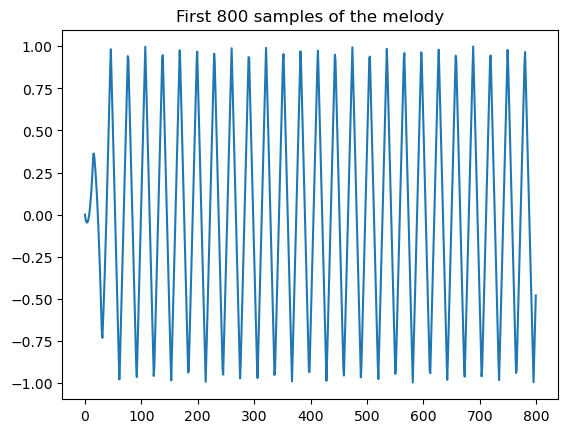

In [6]:
sigtype='triangle'
melody = ['C4','D4','E4','C4','E4','F4','G4','A0','C4','D4','E4','C4','E4','F4','G4']
y=[]
for note in melody:
      x = synth(note2f(note),sigtype=sigtype)
      y = np.append(y,x,axis=0)
display(Audio(y,rate=rate,autoplay=False))
plt.plot(y[0:800])
plt.title("First 800 samples of the melody");